# Importing PySpark and Reading the Dataset

## Importing PySpark

In [226]:
from pyspark.sql import SparkSession, DataFrame

spark = SparkSession.builder.appName("Task02").getOrCreate()

print(spark)

In [227]:
spark.version

'3.5.5'

## Reading the Dataset

In [228]:
file_path = "gold_prices.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)

+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows



In [229]:
df.describe().show()

+-------+------------------+------------------+
|summary|         Buy Price|        Sell Price|
+-------+------------------+------------------+
|  count|              5565|              5565|
|   mean|  45.5656999101527|46.017667565139305|
| stddev|14.892834946578136|15.353833530564659|
|    min|             21.13|             21.19|
|    max|              89.0|              91.3|
+-------+------------------+------------------+



In [230]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Buy Price: double (nullable = true)
 |-- Sell Price: double (nullable = true)



# Generating Samples

In [231]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
import random


def generate_samples(dataset: DataFrame, cols_to_remove: list[str] = None,
                     n_days: int = 10, n_sample: int = 1000, random_state: int = None,
                     target_col: str = "Buy Price") -> DataFrame:
  """
  A function to generate a sample dataframe from a dataset.

  :param dataset: Dataframe for sampling.
  :param cols_to_remove: List of irrelevant columns.
  :param n_days: Range of days prior to t, default is 10.
  :param n_sample: Number of samples to generate, default is 1000.
  :param random_state: Seed to set for consistent reproduction.
  :param target_col: Target column to collect.
  :return: Sample dataframe with n features.
  """

  """
  Generating a list of random indices
  """
  if random_state is not None:
    random.seed(random_state)

  population = range(0, dataset.count())
  sample_indices = random.sample(population, n_sample)

  """
  Collecting the buy price of previous lag_range number of days:
  - Generating a temporary column for indexing
  - Generate values for rows whose index is within sample_indices
  """
  samples = dataset
  features = []
  window = Window.orderBy("Date")
  index_col = "Index"
  samples = samples.withColumn(index_col, F.row_number().over(window))
  condition = F.col(index_col).isin(sample_indices)

  for i in range(1, n_days + 1):
    feature_col = f"t-{i}"
    features.append(feature_col)

    samples = samples.withColumn(
      feature_col,
      F.when(
        condition,
        F.lag(target_col, i, None).over(window)
      ).otherwise(
        F.lit(None)
      )
    )

  """
  Cleaning the dataset:
  - Dropping unnecessary columns as well as null.
  - Changing target_col column name to "Current {target_col}"
  """
  for col in cols_to_remove:
    if col not in features and col != target_col:
      samples = samples.drop(col)

  samples = samples.drop(index_col)
  samples = samples.withColumnRenamed(target_col, f"Current {target_col}")
  samples = samples.dropna()

  """
  Transforming the sample dataframe by collecting feature
   columns into a single column named "Previous {target_col}(s)"
  """
  assembler = VectorAssembler(
    inputCols=features,
    outputCol=f"Previous {target_col}(s)",
  )

  samples = assembler.transform(samples)

  """
  Dropping all the previous feature columns
  """
  for col in features:
    samples = samples.drop(col)

  return samples

In [232]:
sample_df = generate_samples(df, random_state=42, cols_to_remove=["Date", "Sell Price"])
sample_df.show(5)

+-----------------+---------------------+
|Current Buy Price|Previous Buy Price(s)|
+-----------------+---------------------+
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            22.27| [22.22,22.09,21.1...|
+-----------------+---------------------+
only showing top 5 rows



# Training and Predicting

## Splitting the Training and Testing Sets

In [233]:
train_set, test_set = sample_df.randomSplit(weights=[0.7, 0.3], seed=2)

In [234]:
train_set.show(5)

+-----------------+---------------------+
|Current Buy Price|Previous Buy Price(s)|
+-----------------+---------------------+
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            23.04| [23.13,22.92,22.5...|
+-----------------+---------------------+
only showing top 5 rows



In [235]:
test_set.show(5)

+-----------------+---------------------+
|Current Buy Price|Previous Buy Price(s)|
+-----------------+---------------------+
|            22.27| [22.22,22.09,21.1...|
|            23.79| [23.8,23.89,23.89...|
|             26.1| [26.07,26.08,26.1...|
|            26.15| [26.27,26.27,26.4...|
|            26.27| [26.27,26.42,26.4...|
+-----------------+---------------------+
only showing top 5 rows



## Training the Model

In [236]:
from pyspark.ml.regression import LinearRegression

lg = LinearRegression(
  featuresCol="Previous Buy Price(s)",
  labelCol="Current Buy Price",
  solver="l-bfgs",
)

lg_model = lg.fit(train_set)

## Making Predictions

In [237]:
predictions = (lg_model.transform(test_set)
               .withColumnRenamed("prediction", "Predicted Buy Price"))
predictions.show(5)

+-----------------+---------------------+-------------------+
|Current Buy Price|Previous Buy Price(s)|Predicted Buy Price|
+-----------------+---------------------+-------------------+
|            22.27| [22.22,22.09,21.1...|  22.28845683023972|
|            23.79| [23.8,23.89,23.89...| 23.782637528602542|
|             26.1| [26.07,26.08,26.1...|  26.03182188772893|
|            26.15| [26.27,26.27,26.4...|  26.26443792407324|
|            26.27| [26.27,26.42,26.4...|  26.26481827582453|
+-----------------+---------------------+-------------------+
only showing top 5 rows



# Evaluating the Model

In [238]:
def evaluate_model(dataset: DataFrame):
  """
  A function to evaluate the model performance based on a given dataset.
  :param dataset: The dataframe for evaluation.
  :return: Dictionary of evaluation results using different metrics.
  """

  evaluation = lg_model.evaluate(dataset)

  metrics = {
    "Root Mean Squared Error": evaluation.rootMeanSquaredError,
    "Mean Squared Error": evaluation.meanSquaredError,
    "R2": evaluation.r2,
    "Mean Absolute Error": evaluation.meanAbsoluteError,
    "Explained Variance": evaluation.explainedVariance,
    "R2 Adjusted": evaluation.r2adj,
  }

  max_len = 24

  for metric in metrics.keys():
    print(f"{metric:<{max_len}}: {metrics.get(metric):.4f}")

  return metrics

## On the Training Set

In [239]:
train_evaluation = evaluate_model(train_set)

Root Mean Squared Error : 0.3406
Mean Squared Error      : 0.1160
R2                      : 0.9995
Mean Absolute Error     : 0.1577
Explained Variance      : 217.7451
R2 Adjusted             : 0.9995


## On the Testing Set

In [240]:
test_evaluation = evaluate_model(test_set)

Root Mean Squared Error : 0.4115
Mean Squared Error      : 0.1693
R2                      : 0.9993
Mean Absolute Error     : 0.1743
Explained Variance      : 243.6785
R2 Adjusted             : 0.9993


# Illustration Charts

## Line Chart

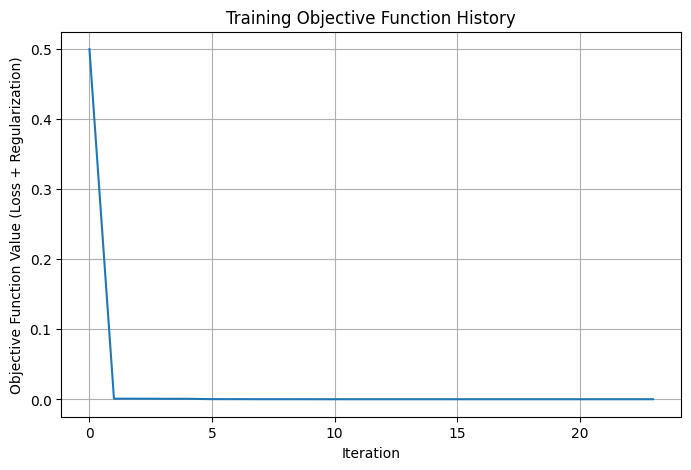

In [241]:
import matplotlib.pyplot as plt

loss_history = lg_model.summary.objectiveHistory

if loss_history:
  plt.figure(figsize=(8, 5))
  plt.plot(loss_history)
  plt.title('Training Objective Function History')
  plt.xlabel('Iteration')
  plt.ylabel('Objective Function Value (Loss + Regularization)')
  plt.grid(True)
  plt.show()

## Bar Chart

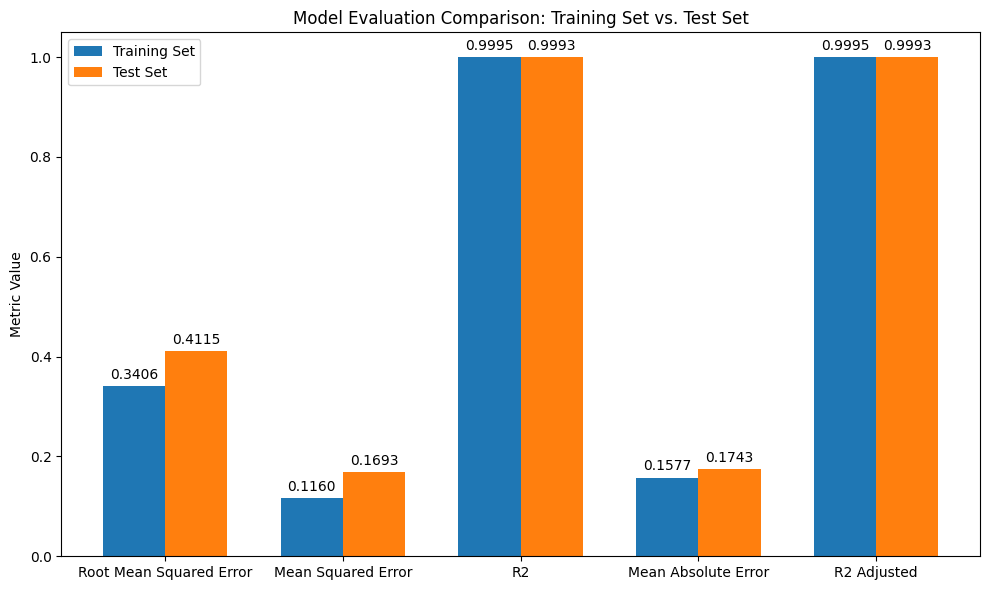

In [242]:
import numpy as np

train_evaluation_copy = train_evaluation.copy()
test_evaluation_copy = test_evaluation.copy()

train_var = train_evaluation_copy.pop("Explained Variance")
test_var = test_evaluation_copy.pop("Explained Variance")

evaluation_metrics = train_evaluation_copy.keys()

x = np.arange(len(evaluation_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width / 2,
                train_evaluation_copy.values(),
                width,
                label='Training Set')
rects2 = ax.bar(x + width / 2,
                test_evaluation_copy.values(),
                width,
                label='Test Set')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Metric Value')
ax.set_title('Model Evaluation Comparison: Training Set vs. Test Set')
ax.set_xticks(x)
ax.set_xticklabels(evaluation_metrics)
ax.legend()

# Optional: Add labels on top of bars for clarity
ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

# Adjust the layout to prevent labels from overlapping
fig.tight_layout()
plt.show()

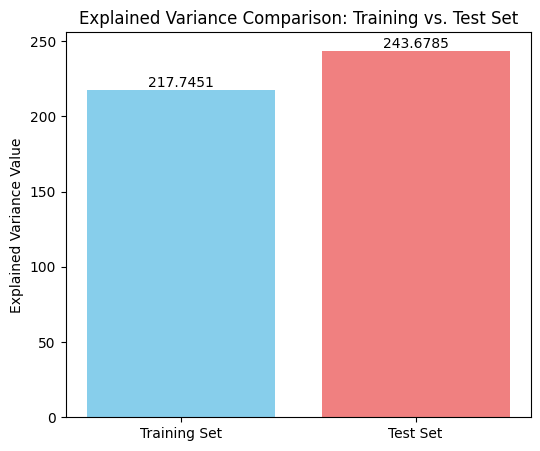

In [243]:
metric_name = "Explained Variance"

sets = ['Training Set', 'Test Set']
values = [train_var, test_var]

plt.figure(figsize=(6, 5))
bars = plt.bar(sets, values, color=['skyblue', 'lightcoral'])

plt.ylabel(f'{metric_name} Value')
plt.title(f'{metric_name} Comparison: Training vs. Test Set')
plt.bar_label(bars, fmt='%.4f')

plt.show()